In [1]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

In [4]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter("torchlogs/")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('mnist_train', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
model = torchvision.models.resnet50(False)
# Have ResNet model take in grayscale rather than RGB
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images)
writer.close()

In [3]:
tensorboard --logdir=runs

SyntaxError: cannot assign to operator (3224537314.py, line 1)

In [9]:
from torchviz import make_dot
#model1 = model()
y = model(x)
make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)


NameError: name 'x' is not defined

In [ ]:
#average network perf
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["Unet resnet18", "Unet mobilenet_v2", "Unet++ resnet18", "Unet++ mobilenet_v2"])
y = np.array([3, 8, 1, 10])

plt.bar(x,y)
plt.show()

In [ ]:
0.2568575676096325 0.15155709078500748 0.3072513911158924   

In [25]:
import cv2 as cv
import numpy as np
from PIL import Image
import os

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import albumentations as A
from skimage.io import imread
from scipy.special import binom
from skimage import feature
from skimage import segmentation
from skimage import morphology
from scipy import ndimage
import cv2 as cv
from scipy import ndimage
from skimage import segmentation
import random
from addnoise import addperlin3

os.chdir("../data")
wallim = Image.open("wall.tiff")
maskim = Image.open("wall.tiff")
wall = np.array(wallim)
mask = np.array(maskim)
damagelevel = 0.5

bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for i in range(N):
        curve += np.outer(bernstein(N - 1, i, t), points[i])
    return curve

class Segment():
    def __init__(self, p1, p2, angle1, angle2, **kw):
        self.p1 = p1; self.p2 = p2
        self.angle1 = angle1; self.angle2 = angle2
        self.numpoints = kw.get("numpoints", 100)
        r = kw.get("r", 0.3)
        d = np.sqrt(np.sum((self.p2-self.p1)**2))
        self.r = r*d
        self.p = np.zeros((4,2))
        self.p[0,:] = self.p1[:]
        self.p[3,:] = self.p2[:]
        self.calc_intermediate_points(self.r)

    def calc_intermediate_points(self,r):
        self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                    self.r*np.sin(self.angle1)])
        self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                    self.r*np.sin(self.angle2+np.pi)])
        self.curve = bezier(self.p,self.numpoints)


def get_curve(points, **kw):
    segments = []
    for i in range(len(points)-1):
        seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
        segments.append(seg)
    curve = np.concatenate([s.curve for s in segments])
    return segments, curve

def ccw_sort(p):
    d = p-np.mean(p,axis=0)
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]

def get_bezier_curve(a, rad=0.2, edgy=0):
    """ given an array of points *a*, create a curve through
    those points. 
    *rad* is a number between 0 and 1 to steer the distance of
          control points.
    *edgy* is a parameter which controls how "edgy" the curve is,
           edgy=0 is smoothest."""
    p = np.arctan(edgy)/np.pi+.5
    a = ccw_sort(a)
    a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
    d = np.diff(a, axis=0)
    ang = np.arctan2(d[:,1],d[:,0])
    f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
    ang = f(ang)
    ang1 = ang
    ang2 = np.roll(ang,1)
    ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
    ang = np.append(ang, [ang[0]])
    a = np.append(a, np.atleast_2d(ang).T, axis=1)
    s, c = get_curve(a, r=rad, method="var")
    x,y = c.T
    return x,y, a


def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
    """ create n random points in the unit square, which are *mindst*
    apart, then scale them."""
    mindst = mindst or .7/n
    a = np.random.rand(n,2)
    d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
    if np.all(d >= mindst) or rec>=200:
        return a*scale
    else:
        return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec+1)



# characterise wall

dtransformwall = ndimage.distance_transform_edt(wall)
labeledwall = segmentation.watershed(dtransformwall, watershed_line=True)
noblocks = labeledwall.max()
spalledwall = wall

#random transforms in each block
 #random depression spalling
        
rad = random.random()
edgy = random.random()*10
npoints = random.randint(3,15)
for c in np.array([[0,0]]):

    a = get_random_points(npoints, scale=1) + c
    x,y, _ = get_bezier_curve(a,rad=rad, edgy=edgy)


x=(x*100).astype(int)
y=(y*100).astype(int)
# plt.plot(x,y)

spall = np.zeros((105,105))

for n in range(len(x)):
  a = min(x[n]+3,102)
  b = min(y[n]+3,102)
  spall[a,b]=1

spall=spall.astype(int)
cv.floodFill(spall, None, (0,0),1)
spall=1-spall
spallD = ndimage.distance_transform_edt(spall)
spall = spallD*100/(max(1,spallD.max())*random.randint(50, 200))


spalllength = int(wall.shape[0]*10/random.randint(10, 150))
spallheight = int(wall.shape[1]*10/random.randint(10, 150))
spallC = cv.resize(spall,(spallheight,spalllength))
spall = spallC

efflor = spall*0
efflor = addperlin3(efflor,1)
spallf = spall*efflor*2

spalllength = spall.shape[0]
spallheight = spall.shape[1]
locx = -spalllength+random.randint(0, wall.shape[0]+2*spalllength)
locy = -spallheight+random.randint(0, wall.shape[1]+2*spallheight)
overlapxstart=max(0,-locx)
overlapxend=max(0,locx+spalllength-wall.shape[0])
overlapystart=max(0,-locy)
overlapyend=max(0,locy+spallheight-wall.shape[1])

defect = spallf[overlapxstart:max(0,spalllength-overlapxend),overlapystart:max(0,spallheight-overlapyend)]
#defect = defect.astype("float32")
# defect = cv.GaussianBlur(defect,(5,5),0)
defectlength = defect.shape[0]
defectheight = defect.shape[1]
#spalledwall[locx+overlapxstart:locx+overlapxstart+defectlength,locy+overlapystart:locy+defectheight+overlapystart] = np.maximum(defect,spalledwall[locx+overlapxstart:locx+overlapxstart+defectlength,locy+overlapystart:locy+defectheight+overlapystart])
spalledwall[locx+overlapxstart:locx+overlapxstart+defectlength,locy+overlapystart:locy+defectheight+overlapystart] = spalledwall[locx+overlapxstart:locx+overlapxstart+defectlength,locy+overlapystart:locy+defectheight+overlapystart]-defect



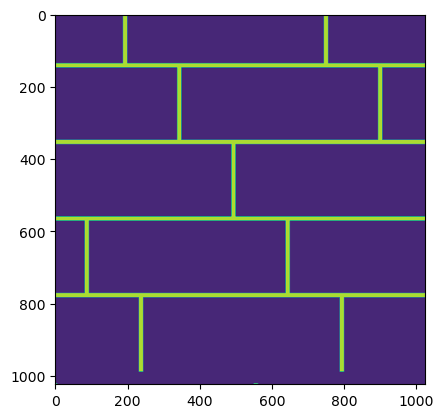

In [5]:
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

#im = Image.open("../data/synth/synthetic_defect_wall3.tiff")
im = Image.open("../data/test1/croppedmasks/10.tiff")
imnp = np.array(im)
#im = cv.imread("synth/synthetic_defect_wall4.tiff")
plt.imshow(imnp)

[0]
X
Y
Z
intensity
return_number
number_of_returns
scan_direction_flag
edge_of_flight_line
classification
synthetic
key_point
withheld
scan_angle_rank
user_data
point_source_id
Int
Chainage
Offset
ArcDist
DefectDepth
LocalH
Coord.__X
Coord.__Y
Coord.__Z
number of points = 6875498
6915 15035 2.1742588575560378
number of pixels = 6879393
width in pixels = 3867
height in pixels = 1779
mean pixel value = 399.11145465005524


0

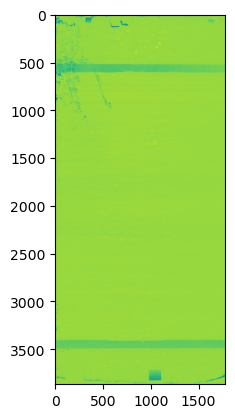

In [21]:
from raster import raster
# INPUTS
# fileloc = location of point cloud
# saveloc = folder for outputs
# mask = denotes whether file is a mask image. mask = 1 skips rasterisation step and resizes to match image dimensions.
# res = multiplier on resolution of rasterised point cloud imagedimension = defaultdimension*res
# dim = if given, resulting image is cropped into dimxdim images and put into relevant mask or image folder ready for network training. 

# INPUT FILES
# if mask = 0, pointcloud or .tiff format image at location: fileloc
# if mask = 1, mask at location: saveloc+"mask.tiff" 
# if mask = 1, image at location: saveloc+ "raster.tiff"

# OUTPUTS
# noim = number of images created

# OUTPUT FILES
# if mask = 0 and input is point cloud, rastered image at location: saveloc+ "raster.tiff"
# if mask = 0 and input is an image, rastered image at location: saveloc+ "raster.tiff"
# if mask = 1, resized mask at location: saveloc+"mask.tiff"
# if dim exists and mask = 0, new folder (if not exists): 'croppedimages/'
# if dim exists and mask = 1, new folder (if not exists): 'croppedmasks/'
# if dim exists and mask = 0, numbered image crops of size dimxdim at location: saveloc+croppedimages/+ str(i) +".tiff"
# if dim exists and mask = 1, numbered mask crops of size dimxdim at location: saveloc+croppedmasks/+ str(i) +".tiff"
fileloc = "../../Incoming data/MartyrWorthy_3mm-flat - Cloud.las"
saveloc = "../dataprep/"
mask = 0
res = 1
dim = None
raster(fileloc,saveloc)

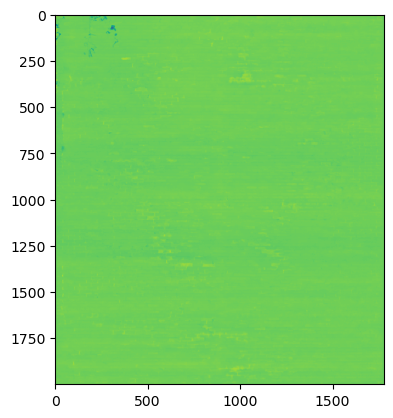

In [23]:
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

#im = Image.open("../data/synth/synthetic_defect_wall3.tiff")
im = Image.open("../dataprep/raster.tiff")
imnp = np.array(im)
#im = cv.imread("synth/synthetic_defect_wall4.tiff")
plt.imshow(imnp[1000:3000,:])

In [29]:
dim = 500
pic = im
#pic = ImageOps.grayscale(pic)
w = pic.size[0]
nx = int(w/dim)
h = pic.size[1]
ny = int(h/dim)
i = 0
print("cropping masks")
for x in range(0, nx):
    for y in range(0, ny):
      i = i+1
      box = (x*dim, y*dim, dim*(1+x) , dim*(1+y))
      region = pic.crop(box)
      #region.save("test2/croppedimagestargetfullres2/"+ str(i) +".png")
      region.save("../dataprep/crops/"+ str(i) +".tiff")
      regionnp = np.array(region)
      import matplotlib.pyplot as plt

    # Get the color map by name:
      cm = plt.get_cmap('gist_rainbow')
      regionnp = regionnp/regionnp.max()
    # Apply the colormap like a function to any array:
      colored_image = cm(regionnp)

    # Obtain a 4-channel image (R,G,B,A) in float [0, 1]
    # But we want to convert to RGB in uint8 and save it:
      Image.fromarray((colored_image[:, :, :3] * 255).astype(np.uint8)).save("../dataprep/crops/"+ str(i) +".png")
    

cropping masks


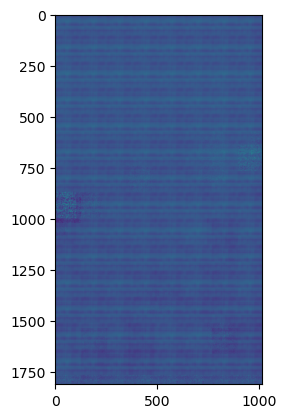

In [19]:
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

#im = Image.open("../data/synth/synthetic_defect_wall3.tiff")
im = Image.open("../data/testsynth0/results/picoutdepthUnetmobilenet_v2default.tiff")
imnp = np.array(im)
#im = cv.imread("synth/synthetic_defect_wall4.tiff")
plt.imshow(imnp)

In [16]:
imnp.min()

0

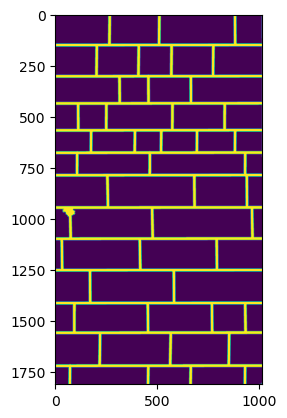

In [4]:
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

#im = Image.open("../data/synth/synthetic_defect_wall3.tiff")
im = Image.open("../data/testmask.tiff")
imnp = np.array(im)
#im = cv.imread("synth/synthetic_defect_wall4.tiff")
plt.imshow(imnp)

In [11]:
imnp[0:500,4]

array([ 96,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,  29, 246, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255,  76,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

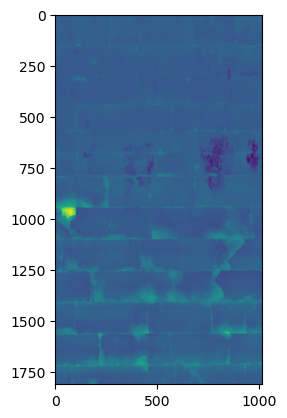

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
#../data/synth/synthetic_defect_wall10.tiff
im = Image.open("../data/test.tiff")
imnp = np.array(im)
#im = cv.imread("synth/synthetic_defect_wall4.tiff")
plt.imshow(imnp)

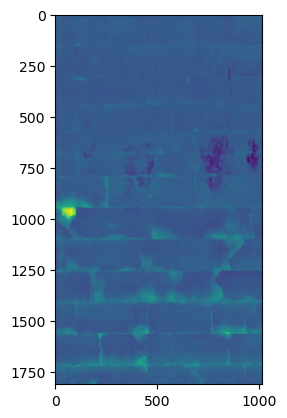

In [2]:
import scipy
filtered = scipy.signal.wiener(imnp, mysize=None, noise=None)
#filtered2 = scipy.signal.median(filtered-imnp, mysize=None, noise=None)#
filtered2 = scipy.ndimage.median_filter(imnp, size=4, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
plt.imshow(filtered2)

In [3]:
imnp.min()

0.0

In [4]:
t = filtered2-imnp
t=10*(t-t.min())
for n in range(0,10):
    t = scipy.ndimage.median_filter(t, size=2, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)


In [5]:
t.mean()

3149433.8

In [6]:
t.min()

2929003.5

In [7]:
filtered.max()

1313780.9650149443

In [8]:
filtered.min()

6509.215819268022

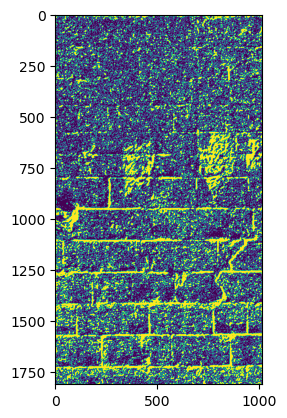

In [11]:
plt.imshow(t>t.mean())

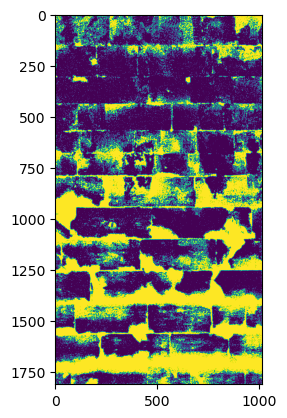

In [12]:
plt.imshow(imnp>imnp.mean())

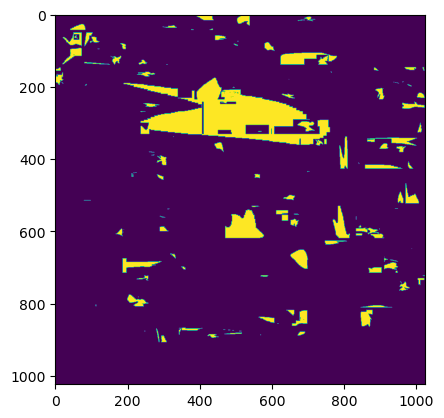

In [21]:
im = Image.open("../data/synth/synthetic_defect_spallmask10.png")
imnp = np.array(im)
#im = cv.imread("synth/synthetic_defect_wall4.tiff")
plt.imshow(imnp)

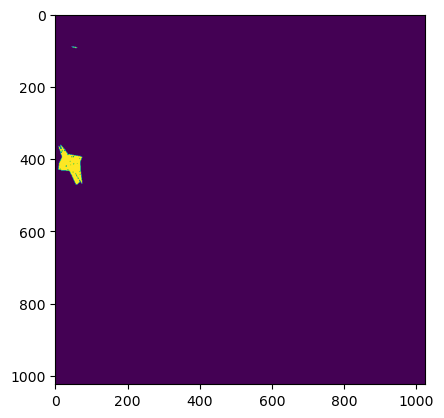

In [37]:
im = Image.open("../data/synth/synthetic_defect_efflorecencemask10.tiff")
imnp = np.array(im)
#im = cv.imread("synth/synthetic_defect_wall4.tiff")
plt.imshow(imnp)

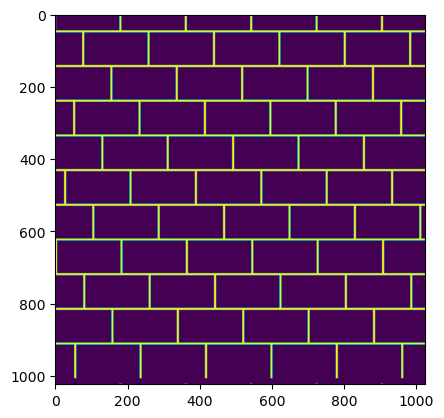

In [38]:
im = Image.open("../data/synth/synthetic_defect_jointmask10.png")
imnp = np.array(im)
#im = cv.imread("synth/synthetic_defect_wall4.tiff")
plt.imshow(imnp)

In [29]:
plt.imshow(spallD)

NameError: name 'spallD' is not defined

In [27]:
efflor2 = addperlin3(efflor,0.1)

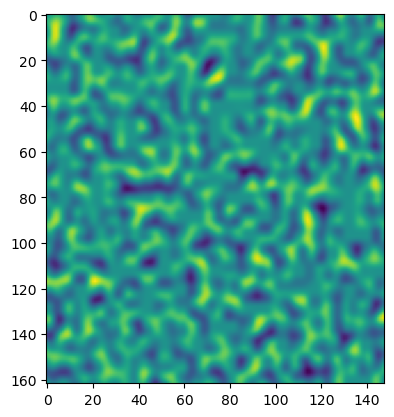

In [28]:
plt.imshow(efflor2)

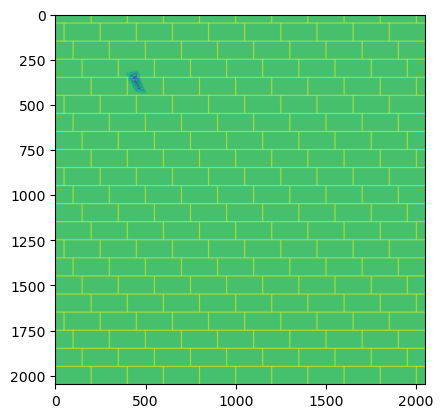

In [29]:
plt.imshow(spalledwall)

In [23]:
efflor.max()

0.8169746357634254

In [24]:
defect.max()

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
plt.imshow(defect)

In [ ]:
    from PIL import Image
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator
    import numpy as np
    import albumentations as A
    from skimage.io import imread
    from scipy.special import binom
    from skimage import feature
    from skimage import segmentation
    from skimage import morphology
    from scipy import ndimage
    import cv2 as cv
    from scipy import ndimage
    from skimage import segmentation
    import random

    bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

    def bezier(points, num=200):
        N = len(points)
        t = np.linspace(0, 1, num=num)
        curve = np.zeros((num, 2))
        for i in range(N):
            curve += np.outer(bernstein(N - 1, i, t), points[i])
        return curve

    class Segment():
        def __init__(self, p1, p2, angle1, angle2, **kw):
            self.p1 = p1; self.p2 = p2
            self.angle1 = angle1; self.angle2 = angle2
            self.numpoints = kw.get("numpoints", 100)
            r = kw.get("r", 0.3)
            d = np.sqrt(np.sum((self.p2-self.p1)**2))
            self.r = r*d
            self.p = np.zeros((4,2))
            self.p[0,:] = self.p1[:]
            self.p[3,:] = self.p2[:]
            self.calc_intermediate_points(self.r)

        def calc_intermediate_points(self,r):
            self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                        self.r*np.sin(self.angle1)])
            self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                        self.r*np.sin(self.angle2+np.pi)])
            self.curve = bezier(self.p,self.numpoints)


    def get_curve(points, **kw):
        segments = []
        for i in range(len(points)-1):
            seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
            segments.append(seg)
        curve = np.concatenate([s.curve for s in segments])
        return segments, curve

    def ccw_sort(p):
        d = p-np.mean(p,axis=0)
        s = np.arctan2(d[:,0], d[:,1])
        return p[np.argsort(s),:]

    def get_bezier_curve(a, rad=0.2, edgy=0):
        """ given an array of points *a*, create a curve through
        those points. 
        *rad* is a number between 0 and 1 to steer the distance of
              control points.
        *edgy* is a parameter which controls how "edgy" the curve is,
               edgy=0 is smoothest."""
        p = np.arctan(edgy)/np.pi+.5
        a = ccw_sort(a)
        a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
        d = np.diff(a, axis=0)
        ang = np.arctan2(d[:,1],d[:,0])
        f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
        ang = f(ang)
        ang1 = ang
        ang2 = np.roll(ang,1)
        ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
        ang = np.append(ang, [ang[0]])
        a = np.append(a, np.atleast_2d(ang).T, axis=1)
        s, c = get_curve(a, r=rad, method="var")
        x,y = c.T
        return x,y, a


    def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
        """ create n random points in the unit square, which are *mindst*
        apart, then scale them."""
        mindst = mindst or .7/n
        a = np.random.rand(n,2)
        d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
        if np.all(d >= mindst) or rec>=200:
            return a*scale
        else:
            return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec+1)


    # characterise wall
    im = Image.open("../data/test.tiff")
    wall = np.array(im)
    spalledwall = wall
    wall2 = wall
    
    
    

    #random depression spalling

    rad = random.random()
    edgy = random.random()*10
    npoints = random.randint(3,15)
    for c in np.array([[0,0]]):

        a = get_random_points(npoints, scale=1) + c
        x,y, _ = get_bezier_curve(a,rad=rad, edgy=edgy)


    x=(x*100).astype(int)
    y=(y*100).astype(int)
   # plt.plot(x,y)

    spall = np.zeros((105,105))

    for n in range(len(x)):
      a = min(x[n]+3,102)
      b = min(y[n]+3,102)
      spall[a,b]=1

    spall=spall.astype(int)
    cv.floodFill(spall, None, (0,0),1)
    spall=1-spall
    spallD = ndimage.distance_transform_edt(spall)
    spall = spallD*100/(max(1,spallD.max())*random.randint(50, 200))


    spalllength = int(wall.shape[0]*100/random.randint(25, 600))
    spallheight = int(wall.shape[1]*100/random.randint(25, 600))
    spallC = cv.resize(spall,(spallheight,spalllength))
    spall = spallC

In [1]:
import numpy as np
from tabulate import tabulate
from UNET import unet
from raster import raster
import os
import shutil
import albumentations as A
from syntheticdamage import syntheticspall, syntheticflor
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from syntheticwall import syntheticwall
import random
from addnoise import addperlin1, addperlin2, addperlin3
import os

damagelist = [0.7]#, 0.55, 0.7, 0.75, 0.8]

damagelevel = damagelist[0]

variationmagnitude = 0.3



os.chdir("../data")            
blocklength = random.randint(50,350)
blockheight = int(max(0.5,random.random())*blocklength/1.3)
wallim = Image.open("wall.tiff")

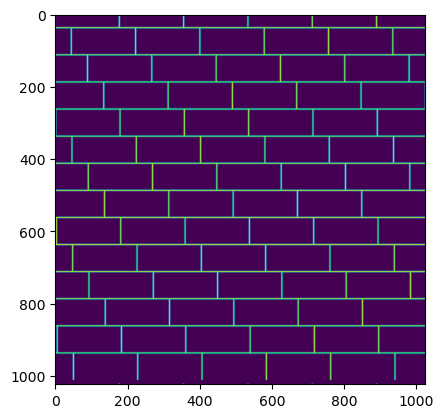

In [7]:
#create wall
synthwall,synthmask = syntheticwall(int(wallim.size[0]/2),int(wallim.size[1]/2),blockheight,blocklength,"syntheticwalltest"+"test"+".tiff")
synthspalledmask = synthmask
plt.imshow(synthwall)

In [8]:
#add spalling
synthspalledwall3 = syntheticspall(synthwall,synthmask,damagelevel)
plt.imshow(synthspalledwall3)

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4055: error: (-215:Assertion failed) inv_scale_x > 0 in function 'cv::resize'


In [ ]:
synthspalledwall2 = syntheticflor(synthspalledwall3,synthmask,damagelevel)
plt.imshow(synthspalledwall2)

AttributeError: 'tuple' object has no attribute 'shape'

In [9]:
wallim = Image.open("test.tiff")
im = np.array(wallim)
im2 = addperlin3(im,1)
plt.imshow(im)

ModuleNotFoundError: No module named 'noise'

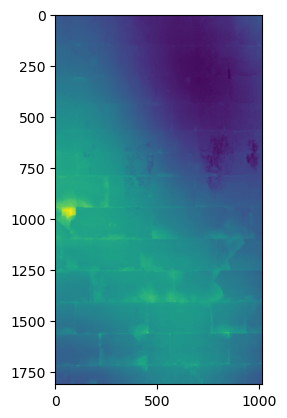

In [5]:
plt.imshow(im2)

In [ ]:


#surface variation
synthspalledwall1 = addperlin1(synthspalledwall2,variationmagnitude)
#wall deformation
synthspalledwall = addperlin2(synthspalledwall1,variationmagnitude*6)

spalledwallim = Image.fromarray(synthspalledwall) 
spalledwallim.save("synth/"+"synthetic_defect_wall"+"test"+".tiff")
#spalledmaskim = Image.fromarray(synthspalledmask*255) 
#spalledmaskim.save("synth/"+"synthetic_defect_mask"+str(n)+".png")


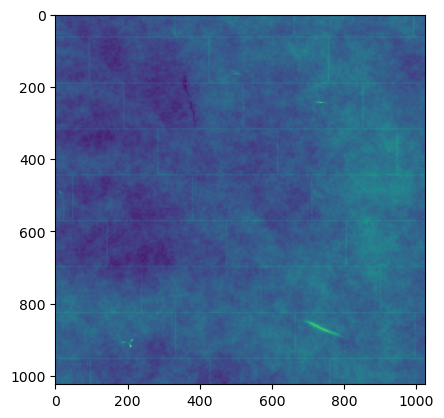

In [4]:
import cv2 as cv
from PIL import Image

im = Image.open("../data/synth/synthetic_defect_wall6.tiff")
imnp = np.array(im)
#im = cv.imread("synth/synthetic_defect_wall4.tiff")
plt.imshow(imnp)

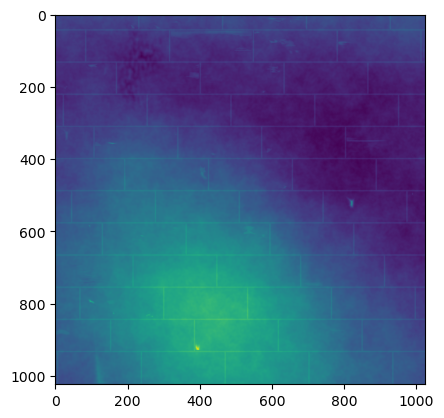

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

im = Image.open("../data/synth/synthetic_defect_wall3.tiff")
imnp = np.array(im)
#im = cv.imread("synth/synthetic_defect_wall4.tiff")
plt.imshow(imnp)

In [ ]:
plt.imshow(spall**0.2)

In [ ]:
def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6*t**5 - 15*t**4 + 10*t**3

    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    leftover0 =  shape[0]-d[0]*res[0]
    leftover1 = shape[1]-d[1]*res[1]
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g00 = np.concatenate((g00,g00[:leftover0,:,:]),axis=0)
    g00 = np.concatenate((g00,g00[:,:leftover1,:]),axis=1)
    g10 = gradients[1:,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = np.concatenate((g10,g10[:leftover0,:,:]),axis=0)
    g10 = np.concatenate((g10,g10[:,:leftover1,:]),axis=1)
    g01 = gradients[0:-1,1:].repeat(d[0], 0).repeat(d[1], 1)
    g01 = np.concatenate((g01,g01[:leftover0,:,:]),axis=0)
    g01 = np.concatenate((g01,g01[:,:leftover1,:]),axis=1)
    g11 = gradients[1:,1:].repeat(d[0], 0).repeat(d[1], 1)
    g11 = np.concatenate((g11,g11[:,:leftover1,:]),axis=1)
    g11 = np.concatenate((g11,g11[:,:leftover1,:]),axis=1)

    # Ramps
    n00 = np.sum(grid * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1])) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0], grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)

In [ ]:
import numpy as np

In [ ]:
res = 7

In [ ]:
res = [res,res]

In [ ]:
shape = [100,50]

In [ ]:
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0)

In [ ]:

delta

In [ ]:
d

In [ ]:
d

In [ ]:
shape[0]-d[0]*res[0]

In [ ]:
grid.shape

In [ ]:
angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
gradients = np.dstack((np.cos(angles), np.sin(angles)))
g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)

In [ ]:
gradients.shape

In [ ]:
gradients[0:-1,0:-1].shape

In [ ]:
gradients[0:-1,0:-1].repeat(d[0], 0).shape

In [ ]:
a = np.array([[1,5,2],[3,1,6],[7,2,4],[8,2,1]])
b = np.dstack((a, a/2))
b.shape

In [ ]:
c=b[:1,:,:]

In [ ]:
c

In [ ]:
b.shape

In [ ]:
d = np.concatenate((b,c),axis=0)

In [ ]:
d.shape

In [ ]:
g00.shape

In [ ]:
grid.shape

In [ ]:
n = np.concatenate((g00,g00[:0,:,:]),axis=0)

In [ ]:
g00[:0,:,:]

In [ ]:
gradients[0,0,:]

In [ ]:
n.shape

In [ ]:
 n00 = np.sum(grid * g00, 2)

In [ ]:
a = np.array([[1,5,2],[3,1,6],[7,2,4],[8,2,1]])

In [ ]:
b = np.dstack((a, a/2))

In [ ]:
b

In [ ]:
c = b

In [ ]:
c.repeat(2,1)

In [ ]:
n00.shape

In [ ]:
n00

In [ ]:
gradients[0:-1,0:-1]

In [ ]:
gradients

In [ ]:
def generate_fractal_noise_2d(shape, res, octaves=1, persistence=0.5):
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2d(shape, (frequency*res[0], frequency*res[1]))
        frequency *= 2
        amplitude *= persistence
        print(_)
        print(frequency)
    return noise

In [ ]:
def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6*t**5 - 15*t**4 + 10*t**3

    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    leftover0 =  shape[0]-d[0]*res[0]
    leftover1 = shape[1]-d[1]*res[1]
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    
    g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g00 = np.concatenate((g00,g00[:leftover0,:,:]),axis=0)
    g00 = np.concatenate((g00,g00[:,:leftover1,:]),axis=1)
    
    g10 = gradients[1:,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = np.concatenate((g10,g10[:leftover0,:,:]),axis=0)
    g10 = np.concatenate((g10,g10[:,:leftover1,:]),axis=1)
    
    g01 = gradients[0:-1,1:].repeat(d[0], 0).repeat(d[1], 1)
    g01 = np.concatenate((g01,g01[:leftover0,:,:]),axis=0)
    g01 = np.concatenate((g01,g01[:,:leftover1,:]),axis=1)
    
    g11 = gradients[1:,1:].repeat(d[0], 0).repeat(d[1], 1)
    g11 = np.concatenate((g11,g11[:leftover0,:,:]),axis=0)
    g11 = np.concatenate((g11,g11[:,:leftover1,:]),axis=1)

    # Ramps
    n00 = np.sum(grid * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1])) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0], grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)

In [ ]:
import numpy as np
shape = [125,240]
res = [3,3]
noise =  generate_perlin_noise_2d(shape,res)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(noise)

In [ ]:
def f(t):
    return 6*t**5 - 15*t**4 + 10*t**3

delta = (res[0] / shape[0], res[1] / shape[1])
d = (shape[0] // res[0], shape[1] // res[1])
leftover0 =  shape[0]-d[0]*res[0]
leftover1 = shape[1]-d[1]*res[1]
grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
# Gradients
angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
gradients = np.dstack((np.cos(angles), np.sin(angles)))

g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)
g00 = np.concatenate((g00,g00[:leftover0,:,:]),axis=0)
g00 = np.concatenate((g00,g00[:,:leftover1,:]),axis=1)

g10 = gradients[1:,0:-1].repeat(d[0], 0).repeat(d[1], 1)
g10 = np.concatenate((g10,g10[:leftover0,:,:]),axis=0)
g10 = np.concatenate((g10,g10[:,:leftover1,:]),axis=1)

g01 = gradients[0:-1,1:].repeat(d[0], 0).repeat(d[1], 1)
g01 = np.concatenate((g01,g01[:leftover0,:,:]),axis=0)
g01 = np.concatenate((g01,g01[:,:leftover1,:]),axis=1)

g11 = gradients[1:,1:].repeat(d[0], 0).repeat(d[1], 1)
g11 = np.concatenate((g11,g11[:leftover0,:,:]),axis=0)
g11 = np.concatenate((g11,g11[:,:leftover1,:]),axis=1)

# Ramps
n00 = np.sum(grid * g00, 2)
n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1])) * g10, 2)
n01 = np.sum(np.dstack((grid[:,:,0], grid[:,:,1]-1)) * g01, 2)
n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)

t = f(grid)
n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
nois = np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)

In [ ]:
np.sum([[1,2,4],[2,8,2]],1)

In [ ]:
plt.imshow(n1)

In [ ]:
import noise
n1 = noise.pnoise2(5,17, octaves=3, persistence=0.5, lacunarity=2.0, repeat=1024, base=0.0)

In [ ]:
shape = (104,104)
scale = 1
octaves = 2
persistence = 0.5
lacunarity = 2.0
seed = np.random.randint(0,100)

world = np.zeros(shape)

# make coordinate grid on [0,1]^2
x_idx = np.linspace(0, 1, shape[0])
y_idx = np.linspace(0, 1, shape[1])
world_x, world_y = np.meshgrid(x_idx, y_idx)

# apply perlin noise, instead of np.vectorize, consider using itertools.starmap()
world = np.vectorize(noise.pnoise2)(world_x/scale,
                        world_y/scale,
                        octaves=octaves,
                        persistence=persistence,
                        lacunarity=lacunarity,
                        repeatx=1024,
                        repeaty=1024,
                        base=seed)

# here was the error: one needs to normalize the image first. Could be done without copying the array, though
img = (world + 0.5) #.astype(np.uint8) # <- Normalize world first


In [ ]:
import cv2 as cv
from PIL import Image

im = Image.open("../data/synth/synthetic_defect_wall1.tiff")
imnp = np.array(im)
#im = cv.imread("synth/synthetic_defect_wall4.tiff")
plt.imshow(imnp)

In [ ]:
im = Image.open("../data/test.tiff")
imnp = np.array(im)
#im = cv.imread("synth/synthetic_defect_wall4.tiff")
plt.imshow(imnp)

In [ ]:
img.max()


In [ ]:
plt.imshow(img)

In [ ]:
plt.imshow(t[:,:,0])

In [ ]:
plt.imshow(g00[:,:,0])

In [ ]:
plt.imshow((grid * g00)[:,:,0])

In [ ]:
plt.imshow(grid[:,:,0])

In [ ]:
plt.imshow(n00)

In [ ]:
#note: (2^octaves)* res[n] must be <= shape[n]

import math 

octaves = 5

tot = min(octaves,min(shape[0]/res[0],shape[1]/res[1]))
octaves = math.log(tot,2)
print(octaves)

noise2 = generate_fractal_noise_2d(shape, res, octaves=octaves, persistence=0.5)
plt.imshow(noise2)

In [ ]:

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import albumentations as A
from skimage.io import imread
from scipy.special import binom
from skimage import feature
from skimage import segmentation
from skimage import morphology
from scipy import ndimage
import cv2 as cv
from scipy import ndimage
from skimage import segmentation
import random

bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for i in range(N):
        curve += np.outer(bernstein(N - 1, i, t), points[i])
    return curve

class Segment():
    def __init__(self, p1, p2, angle1, angle2, **kw):
        self.p1 = p1; self.p2 = p2
        self.angle1 = angle1; self.angle2 = angle2
        self.numpoints = kw.get("numpoints", 100)
        r = kw.get("r", 0.3)
        d = np.sqrt(np.sum((self.p2-self.p1)**2))
        self.r = r*d
        self.p = np.zeros((4,2))
        self.p[0,:] = self.p1[:]
        self.p[3,:] = self.p2[:]
        self.calc_intermediate_points(self.r)

    def calc_intermediate_points(self,r):
        self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                    self.r*np.sin(self.angle1)])
        self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                    self.r*np.sin(self.angle2+np.pi)])
        self.curve = bezier(self.p,self.numpoints)


def get_curve(points, **kw):
    segments = []
    for i in range(len(points)-1):
        seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
        segments.append(seg)
    curve = np.concatenate([s.curve for s in segments])
    return segments, curve

def ccw_sort(p):
    d = p-np.mean(p,axis=0)
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]

def get_bezier_curve(a, rad=0.2, edgy=0):
    """ given an array of points *a*, create a curve through
    those points. 
    *rad* is a number between 0 and 1 to steer the distance of
          control points.
    *edgy* is a parameter which controls how "edgy" the curve is,
           edgy=0 is smoothest."""
    p = np.arctan(edgy)/np.pi+.5
    a = ccw_sort(a)
    a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
    d = np.diff(a, axis=0)
    ang = np.arctan2(d[:,1],d[:,0])
    f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
    ang = f(ang)
    ang1 = ang
    ang2 = np.roll(ang,1)
    ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
    ang = np.append(ang, [ang[0]])
    a = np.append(a, np.atleast_2d(ang).T, axis=1)
    s, c = get_curve(a, r=rad, method="var")
    x,y = c.T
    return x,y, a


def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
    """ create n random points in the unit square, which are *mindst*
    apart, then scale them."""
    mindst = mindst or .7/n
    a = np.random.rand(n,2)
    d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
    if np.all(d >= mindst) or rec>=200:
        return a*scale
    else:
        return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec+1)


In [ ]:
im = Image.open("test10/croppedimages/36.tiff")
imnp = np.array(im)
plt.imshow(imnp, cmap = 'gray')

In [ ]:
from skimage.util import random_noise

im = Image.open("synth/testsynth2/1/croppedimages/8.tiff")
# convert PIL Image to ndarray
im_arr = np.asarray(im)

# random_noise() method will convert image in [0, 255] to [0, 1.0],
# inherently it use np.random.normal() to create normal distribution
# and adds the generated noised back to image
#noise_img = random_noise(im_arr, mode='speckle', var=0.05**0.8)
#noise_img = random_noise(noise_img, mode='gaussian')#, var=0.05**0.8)
noise_img = (255*noise_img).astype(np.uint8)

img = Image.fromarray(noise_img)
img.show()

In [ ]:
im.save("paper.png")

In [ ]:
overlapxstart


In [ ]:
overlapystart

In [ ]:
overlapyend

In [ ]:
overlapxend

In [ ]:
spallheight

In [ ]:
spalllength

In [ ]:
spallD.max()

In [ ]:
plt.imshow(labeledwall)

In [ ]:
mask = wall>0.9

In [ ]:
plt.imshow(mask)

In [ ]:
mask2 = mask.astype("uint8")

In [ ]:
out=cv.connectedComponents(1-mask2)

In [ ]:
out[1]

In [ ]:
plt.imshow(out[1])

In [ ]:
defect.shape

In [ ]:
np.maximum(defect,spalledwall[locx+overlapxstart:locx+overlapxstart+defectlength,locy+overlapystart:locy+defectheight+overlapystart])

In [ ]:
plt.imshow(defect)

In [ ]:
plt.imshow(spall)

In [ ]:
from RUN import UNETrun
from raster import raster
from PIL import Image
from UNET import unet
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dim = 512
saveloc = "test4/"
fileloc = "SGE01-flat - Cloud2.las"
mask = 0
res = 2
noim = raster(fileloc,saveloc,mask,res, dim)

In [ ]:
dim = 512
saveloc = "test4/"
fileloc = "test2/maskfullres.png"
mask = 1
res = 2
noim = raster(fileloc,saveloc,mask,res, dim)

In [ ]:
pic = Image.open(saveloc+"croppedimages/3.tiff")
picmask = Image.open(saveloc+"croppedmasks/3.tiff")

In [ ]:
picnp = np.asarray(pic)
picnpmask = np.asarray(picmask)

In [ ]:
plt.imshow(picnpmask)

In [ ]:
plt.imshow(picnp)

In [ ]:
picnp.shape

In [ ]:
Z

In [ ]:


unet(test, inno, imagelocation, results_path, nepochs, network, encoder, pretrain)

In [ ]:
from RUN import UNETrun
from raster import raster
from PIL import Image
from UNET import unet
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
    from sklearn.model_selection import train_test_split
    import pathlib
    imagelocation ='test4/'
    def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
        """Returns a list of files in a directory/path. Uses pathlib."""
        filenames = [file for file in path.glob(ext) if file.is_file()]
        return filenames

    root = pathlib.Path.cwd()
    # input and target files
    inputs = get_filenames_of_path(root / (imagelocation+"croppedimages"))

In [ ]:
from raster import raster
saveloc = 'test4/'
fileloc = "SGE01-flat - Cloud_test.las"
raster(fileloc,saveloc,mask = 0,res=2)

In [ ]:
from raster import raster
saveloc = 'test4/'
fileloc = "testmask.png"
raster(fileloc,saveloc,mask = 1,res=2)

In [ ]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
test = Image.open("test8/croppedimages/4.tiff")

In [ ]:
testnp = np.asarray(test)
plt.imshow(testnp)

In [ ]:
testnp.shape[0]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0, 350, 1)
Y = np.arange(0, 350, 1)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, out[0:350,0:350], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
testnp = np.asarray(test)
plt.imshow(testnp)

In [ ]:
testnp.max()

In [ ]:
testnp.min()

In [ ]:
testnp.mean()

In [ ]:
#testnp = 255*(testnp-testnp.min())/(testnp.max()-testnp.min())
testnp = testnp.astype('uint8')

In [ ]:
plt.imshow(-testnp)

In [ ]:
testnp

In [ ]:

plt.hist(testnp.ravel(),256,[0,256])  # arguments are passed to np.histogram

plt.show()

In [ ]:
from PIL import Image, ImageOps
import numpy as np
wallpil = Image.open("wall.tiff")
wall = np.array(wallpil)

In [ ]:
import cv2 as cv
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage import segmentation
dtransformwall = ndimage.distance_transform_edt(wall)
labeledwall = segmentation.watershed(dtransformwall, watershed_line=True)


In [ ]:
print(labeledwall)

In [ ]:
plt.imshow(labeledwall)

In [ ]:
block = (labeledwall==20)

In [ ]:
plt.imshow(block)

In [ ]:
blockindex = np.transpose(np.nonzero(block))
blockxstart=blockindex[:,0].min()
blockxend=blockindex[:,0].max()
blockystart=blockindex[:,1].min()
blockyend=blockindex[:,1].max()
plt.imshow(block[blockxstart:blockxend,blockystart:blockyend])

In [ ]:
blockindex

In [ ]:
wall = np.array(mask)

In [ ]:
masknp = (wall > 0.05).astype(np.uint8)

In [ ]:
masknp*=255

In [ ]:
mask = Image.fromarray(masknp)

In [ ]:
mask

In [ ]:
masknp.dtype

In [ ]:
mask.save("mask.png")

In [9]:
import albumentations as A
from PIL import Image
from skimage.io import imread
import matplotlib.pyplot as plt
transparams = [
   # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
   # A.HorizontalFlip(p=0.5),
    #A.VerticalFlip(p=0.5),
    #A.RandomBrightnessContrast(p=1),
   # A.GaussNoise(always_apply=True, var_limit=(8,8)),
  #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
    #A.RandomRotate90(always_apply=False, p=0.75),
    A.ElasticTransform(p=1, alpha=500, sigma=40, alpha_affine=8),
   #A.OpticalDistortion (distort_limit=0.05, shift_limit=0.05, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1),
   # A.GridDistortion (num_steps=5, distort_limit=0.2, interpolation=1, border_mode=4, value=None, mask_value=None, normalized=True, always_apply=False, p=1)
]

In [12]:
from PIL import Image
im = Image.open("../data/test.tiff")
imnp = np.array(im)
ma = Image.open("../data/testmask.tiff")
manp = np.array(ma)
transform1 = A.Compose(transparams)
transformed1 = transform1(image=imnp, mask=manp)
x = transformed1['image']
y = transformed1['mask']


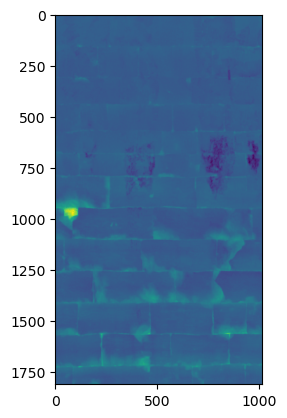

In [14]:
plt.imshow(x)

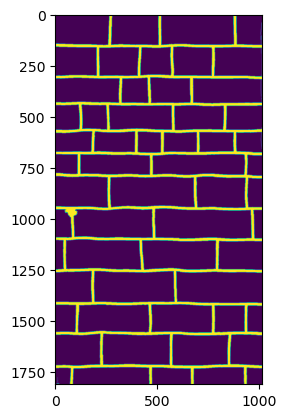

In [15]:
plt.imshow(y)

In [ ]:

import numpy as np
a = np.zeros((2,3))

In [ ]:
a.shape

In [ ]:
import numpy as np
from scipy.special import binom
import matplotlib.pyplot as plt


bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for i in range(N):
        curve += np.outer(bernstein(N - 1, i, t), points[i])
    return curve

class Segment():
    def __init__(self, p1, p2, angle1, angle2, **kw):
        self.p1 = p1; self.p2 = p2
        self.angle1 = angle1; self.angle2 = angle2
        self.numpoints = kw.get("numpoints", 100)
        r = kw.get("r", 0.3)
        d = np.sqrt(np.sum((self.p2-self.p1)**2))
        self.r = r*d
        self.p = np.zeros((4,2))
        self.p[0,:] = self.p1[:]
        self.p[3,:] = self.p2[:]
        self.calc_intermediate_points(self.r)

    def calc_intermediate_points(self,r):
        self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                    self.r*np.sin(self.angle1)])
        self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                    self.r*np.sin(self.angle2+np.pi)])
        self.curve = bezier(self.p,self.numpoints)


def get_curve(points, **kw):
    segments = []
    for i in range(len(points)-1):
        seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
        segments.append(seg)
    curve = np.concatenate([s.curve for s in segments])
    return segments, curve

def ccw_sort(p):
    d = p-np.mean(p,axis=0)
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]

def get_bezier_curve(a, rad=0.2, edgy=0):
    """ given an array of points *a*, create a curve through
    those points. 
    *rad* is a number between 0 and 1 to steer the distance of
          control points.
    *edgy* is a parameter which controls how "edgy" the curve is,
           edgy=0 is smoothest."""
    p = np.arctan(edgy)/np.pi+.5
    a = ccw_sort(a)
    a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
    d = np.diff(a, axis=0)
    ang = np.arctan2(d[:,1],d[:,0])
    f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
    ang = f(ang)
    ang1 = ang
    ang2 = np.roll(ang,1)
    ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
    ang = np.append(ang, [ang[0]])
    a = np.append(a, np.atleast_2d(ang).T, axis=1)
    s, c = get_curve(a, r=rad, method="var")
    x,y = c.T
    return x,y, a


def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
    """ create n random points in the unit square, which are *mindst*
    apart, then scale them."""
    mindst = mindst or .7/n
    a = np.random.rand(n,2)
    d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
    if np.all(d >= mindst) or rec>=200:
        return a*scale
    else:
        return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec+1)

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect("equal")

rad = 0.2
edgy = 0.05

for c in np.array([[0,0]]):

    a = get_random_points(n=7, scale=1) + c
    x,y, _ = get_bezier_curve(a,rad=rad, edgy=edgy)
    plt.plot(x,y)

plt.show()


In [ ]:
x=(x*100).astype(int)
y=(y*100).astype(int)
plt.plot(x,y)

In [ ]:
spall = np.zeros((100,100))

In [ ]:
for n in range(len(x)):
  a = x[n]
  b = y[n]
  spall[a,b]=1

In [ ]:
plt.imshow(spall)

In [ ]:
import cv2 as cv

In [ ]:
spall=spall.astype(int)
cv.floodFill(spall, None, (0,0),1)

In [ ]:
plt.imshow(spall)

In [ ]:

spall=1-spall

In [ ]:
plt.imshow(spall)

In [ ]:
from PIL import Image
spallim = Image.fromarray(spall)

In [ ]:
from scipy import ndimage

In [ ]:
#distance transform
#random distance transform with lines
##random flat regions
#antialiasing

In [ ]:
spallD = ndimage.distance_transform_edt(spall)

In [ ]:
plt.imshow(spallD)

In [ ]:
#spallim = spallim.resize((100,100),resample=Image.LANCZOS)

In [ ]:
spallimnp = np.array(spallim)

In [ ]:
plt.imshow(spallimnp)

In [ ]:
import cv2
spallimnp2 = spallimnp
spallimnp2 = spallimnp2.astype("float32")
cv2.blur(spallimnp2,(10,10)) 
plt.imshow(spallimnp2)

In [ ]:
import cv2
spallimnp2 = spallimnp
spallimnp2 = spallimnp2.astype("float32")
kernel = np.ones((5,5),np.float32)/25
#kernel = kernel.astype("int")
dst = cv.filter2D(spallimnp2,-1,kernel)
plt.imshow(dst)

In [ ]:

import cv2 as cv
spallimnp2 = spallimnp
spallimnp2 = spallimnp2.astype("float32")
blur = cv.GaussianBlur(spallimnp2,(5,5),0)
plt.imshow(blur)

In [ ]:
blur.max()

In [ ]:
plt.imshow(blur)

In [ ]:
spallimnp2 = spallimnp.astype("float32")
spallimnpdown = cv2.resize(spallimnp2, [10,10])

In [ ]:
spallD2 = np.array(spallD)
plt.imshow(spallD2)

In [ ]:
spallD2 = np.array(spallD)
spallimnpdown=spallimnpdown*spallD2[35,35]
spallD2[30:40,30:40] = np.where(spallimnpdown>0,spallimnpdown, spallD2[30:40,30:40])
plt.imshow(spallD2)

In [ ]:
spallD2 = spallD2.astype("float32")
blur = cv.GaussianBlur(spallD2,(3,3),0)
plt.imshow(blur)

In [ ]:
#wall = Image.open(wall.tiff)
transform1 = A.Compose(transparams)


# Load input and target
wall = imread("wall.tiff")
maxinput = wall.max()
wall = wall/maxinput

mask = imread("mask.png")



In [ ]:
spall.shape

In [ ]:


from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import albumentations as A
from skimage.io import imread
from scipy.special import binom
from skimage import feature
from skimage import segmentation
from skimage import morphology
from scipy import ndimage
import cv2 as cv
from scipy import ndimage
from skimage import segmentation

wall = cv.imread("wall.tiff")
mask = cv.imread("mask.tiff")
damagelevel = 0.5
bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for i in range(N):
        curve += np.outer(bernstein(N - 1, i, t), points[i])
    return curve

class Segment():
    def __init__(self, p1, p2, angle1, angle2, **kw):
        self.p1 = p1; self.p2 = p2
        self.angle1 = angle1; self.angle2 = angle2
        self.numpoints = kw.get("numpoints", 100)
        r = kw.get("r", 0.3)
        d = np.sqrt(np.sum((self.p2-self.p1)**2))
        self.r = r*d
        self.p = np.zeros((4,2))
        self.p[0,:] = self.p1[:]
        self.p[3,:] = self.p2[:]
        self.calc_intermediate_points(self.r)

    def calc_intermediate_points(self,r):
        self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                    self.r*np.sin(self.angle1)])
        self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                    self.r*np.sin(self.angle2+np.pi)])
        self.curve = bezier(self.p,self.numpoints)


def get_curve(points, **kw):
    segments = []
    for i in range(len(points)-1):
        seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
        segments.append(seg)
    curve = np.concatenate([s.curve for s in segments])
    return segments, curve

def ccw_sort(p):
    d = p-np.mean(p,axis=0)
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]

def get_bezier_curve(a, rad=0.2, edgy=0):
    """ given an array of points *a*, create a curve through
    those points. 
    *rad* is a number between 0 and 1 to steer the distance of
          control points.
    *edgy* is a parameter which controls how "edgy" the curve is,
           edgy=0 is smoothest."""
    p = np.arctan(edgy)/np.pi+.5
    a = ccw_sort(a)
    a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
    d = np.diff(a, axis=0)
    ang = np.arctan2(d[:,1],d[:,0])
    f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
    ang = f(ang)
    ang1 = ang
    ang2 = np.roll(ang,1)
    ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
    ang = np.append(ang, [ang[0]])
    a = np.append(a, np.atleast_2d(ang).T, axis=1)
    s, c = get_curve(a, r=rad, method="var")
    x,y = c.T
    return x,y, a


def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
    """ create n random points in the unit square, which are *mindst*
    apart, then scale them."""
    mindst = mindst or .7/n
    a = np.random.rand(n,2)
    d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
    if np.all(d >= mindst) or rec>=200:
        return a*scale
    else:
        return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec+1)


# characterise wall

dtransformwall = ndimage.distance_transform_edt(wall)
labeledwall = segmentation.watershed(dtransformwall, watershed_line=True)
noblocks = labeledwall.max()
spalledwall = wall
#plt.imshow(wall)
#random transforms in each block
for n1 in range(noblocks+1):
    n1=n1+1
    print(n1)
    block = (labeledwall==n1)
    block.astype("int")

    blockindex = np.transpose(np.nonzero(block))
    blockxstart=blockindex[:,0].min()
    blockxend=blockindex[:,0].max()
    blockystart=blockindex[:,1].min()
    blockyend=blockindex[:,1].max()
    blocklength = blockxend-blockxstart
    blockheight = blockyend-blockystart 
    thisblock = block[blockxstart:blockxend,blockystart:blockyend]

    if  (random.random() < damagelevel)==1:
        for n2 in range(random.randint(0, 10*damagelevel)):



            rad = 0.2
            edgy = 0.05

            for c in np.array([[0,0]]):

                a = get_random_points(n=7, scale=1) + c
                x,y, _ = get_bezier_curve(a,rad=rad, edgy=edgy)


            x=(x*100).astype(int)
            y=(y*100).astype(int)
            plt.plot(x,y)

            spall = np.zeros((100,100))

            for n in range(len(x)):
              a = x[n]
              b = y[n]
              spall[a,b]=1

            spall=spall.astype(int)
            cv.floodFill(spall, None, (0,0),1)
            spall=1-spall
            spallD = ndimage.distance_transform_edt(spall)
            spalllength = int(blocklength/random.randint(0, 4))
            spallheight = int(blockheight/random.randint(0, 4))
            spall = cv.resize(spallD,(spalllength,spallheight))

            locx = blockxstart-spalllength+random.randint(0, blocklength+2*spalllength)
            locy =blockystart-spallheight+random.randint(0, blockheight+2*spallheight)
            overlapxstart=max(0,blockxstart-locx)
            overlapxend=max(0,locx+spalllength-blockxend)
            overlapystart=max(0,blockystart-locy)
            overlapyend=max(0,locy+spallheight-blockyend)

            defect = spall[overlapxstart:spalllength-overlapxend,overlapystart:spallheight-overlapyend]
            defectlength = defect.shape()[0]
            defectheight = defect.shape()[1]
            spalledwall[locx+overlapxstart:locx+overlapxstart+defectlength,locy+overlapystart:locy+defectheight+overlapystart] = np.maximum(defect,spalledwall[locx+overlapxstart:locx+overlapxstart+defectlength,locy+overlapystart:locy+defectheight+overlapystart])

spallingmask = spalledwall>0


In [ ]:
#wall[100:200,200:300]+=spall
wall[100:200,200:300]=np.maximum(spall,wall[100:200,200:300])

In [ ]:
plt.imshow(wall[0:250,0:350])

In [ ]:
transformed1 = transform1(image=wall, mask=mask)
x = transformed1['image']
y = transformed1['mask']
out=x*maxinput

In [ ]:
plt.imshow(out)


In [ ]:
def fill_contours_fixed(arr):
    return np.maximum.accumulate(arr, 1) &\
           np.maximum.accumulate(arr[:, ::-1], 1)[:, ::-1] &\
           np.maximum.accumulate(arr[::-1, :], 0)[::-1, :] &\
           np.maximum.accumulate(arr, 0)

fill_contours_fixed(spall)

In [ ]:
x

In [ ]:
plt.imshow(x)

In [ ]:
from perlin_noise import PerlinNoise

noise = PerlinNoise(octaves=10, seed=1)
xpix, ypix = 100, 100
pic = [[noise([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)]

In [ ]:
import noise
    
pnoise2 = noise2(x, y, octaves=1, persistence=0.5, lacunarity=2.0, repeatx=1024, repeaty=1024, base=0.0)


In [ ]:
import noise
help(noise)

In [ ]:
import os

path1 = 'C:/Users/eejmws/OneDrive - University of Leeds/Pytorch/'
path2 = 'C:/Users/jackm/OneDrive - University of Leeds/Pytorch/'
 
isdir1 = os.path.isdir(path1) 
isdir2 = os.path.isdir(path2) 

if isdir1 == True:
    os.chdir(path1)
elif isdir2 == True:
    os.chdir(path2)
else:
    print("directory not found")


In [ ]:
#test different damage levels for synthetic
import numpy as np
from tabulate import tabulate
from UNET import unet
from raster import raster
import os
import shutil
import albumentations as A
from synthetic_spalling import syntheticspall
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
saveloc = ['testideal2/','testideal2/','testideal3/']#,'testideal4/','testideal5/']
testmaskfile = "testmask.tiff"
testfile = "test.tiff"
cloud ="synthetic_defect_wall.tiff"
maskfile = "mask.png"
#reslist = [0.7, 1, 1.5, 2, 3, 4]
damagelist = [0.7]#, 0.55, 0.7, 0.75, 0.8]
res1 = 2
dimlist = [256]
table = [['Network', 'encoder', 'epochs', 'IOU', 'Precision', 'recall','dim']]
#for dim1, saveloc in zip(dimlist,saveloc):
for damagelevel, saveloc in zip(damagelist,saveloc):
    dim1 = dimlist[0]
    testim = Image.open("test.tiff")
    wallim = Image.open("wall.tiff")
    #maskim = Image.open("wall.tiff")
    wall = np.array(wallim)
    #mask = np.array(maskim)
    mask = wall>0.9
    test = np.array(testim)
   #damagelevel = 0.7
    spalledwall,spallingmask = syntheticspall(wall,mask,damagelevel)
    spalledwallim = Image.fromarray(spalledwall) 
    spalledwallim.save("synthetic_defect_wall.tiff")
    
    try:
        os.makedirs(saveloc)
        os.makedirs(saveloc+"results/")
        
    except OSError:
        pass  
    shutil.copyfile(testfile, saveloc+testfile)
    shutil.copyfile(testmaskfile, saveloc+testmaskfile)
    shutil.copyfile(cloud, saveloc+cloud)
    shutil.copyfile(maskfile, saveloc+maskfile)
    raster(cloud,saveloc,mask = 0,res=res1,dim=dim1) 
    raster(maskfile,saveloc,mask = 1,res=res1, dim = dim1) 
    encoderstotest = ['mobilenet_v2']
    networkstotest = ['Unet']#,'UnetPlusPlus','DeepLabV3']
    test = 1
    n = 0
    
    
    transparams = [
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.7),
        A.GaussNoise(always_apply=False, p=1, var_limit=(3, 9)),
      #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
       # A.RandomRotate90(always_apply=False, p=0.75)
       # A.CLAHE(p=1),

    ]
    transparamsv = [
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.7),
        A.GaussNoise(always_apply=False, p=1, var_limit=(5, 5)),
      #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
       # A.RandomRotate90(always_apply=False, p=0.75)
       # A.CLAHE(p=1),

    ]
    
    for network in networkstotest:
        for encoder in encoderstotest:
            pretrain = "imagenet"
            if dim1 >= 512:
                 batch = 2
            else:
                 batch = 4
            path =saveloc
            inno=1
            nepochs = 300
            print(network)
            print(encoder)
            #try:
            iou_score,precision,recall,epochsf = unet(test, inno, batch, path, nepochs, network, encoder, pretrain, dim1, transparams, transparamsv)
            print(iou_score)
            table.append([network, encoder, epochsf, iou_score, precision, recall, dim1])
            #except:
            print('training failed')#
            
print(tabulate(table))

In [ ]:
#synthetic wall random
from syntheticwall import syntheticwall
import random
blocklength = random.randint(50,350)
blockheight = int(random.random()*blocklength/1.3)
syntheticwall(512,512,blockheight,blocklength,"syntheticwalltest.tiff")
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
im = Image.open("syntheticwalltest.tiff")
imnp = np.array(im)
plt.imshow(imnp)

In [ ]:
#test synthetic vs real
import numpy as np
from tabulate import tabulate
from UNET import unet
from raster import raster
import os
import shutil
import albumentations as A
from synthetic_spalling import syntheticspall
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from syntheticwall import syntheticwall
import random

saveloc = ['testsynth0/','testsynth0.1/''testsynth1/','testsynth2/','testsynth3/','testsynth4/']#,'testideal4/','testideal5/']
testmaskfile = "testmask.tiff"
testfile = "test.tiff"
#cloud ="synthetic_defect_wall.tiff"
#maskfile = "mask.png"
cloud ="traincloud.las"
maskfile = "mask.png"
#reslist = [0.7, 1, 1.5, 2, 3, 4]
damagelist = [0.7]#, 0.55, 0.7, 0.75, 0.8]

damagelevel = damagelist[0]

testim = Image.open("test.tiff")
wallim = Image.open("wall.tiff")



res1 = 2
dimlist = [256]
dim1 = dimlist[0]
synthproplist = [0,0.1,0.2, 0.5,1,2]
table = [['Network', 'encoder', 'epochs', 'IOU', 'Precision', 'recall','dim']]
#for dim1, saveloc in zip(dimlist,saveloc):

x = 30
os.makedirs("synth/")

for n in range(0,x):

    t = 1
    while t == 1:

        try:
            blocklength = random.randint(50,350)
            blockheight = int(max(0.5,random.random())*blocklength/1.3)
            synthwall,synthmask = syntheticwall(int(wallim.size[0]/2),int(wallim.size[1]/2),blockheight,blocklength,"syntheticwalltest"+str(n)+".tiff")
            synthspalledmask = synthmask
            synthspalledwall = syntheticspall(synthwall,synthmask,damagelevel)
            spalledwallim = Image.fromarray(synthspalledwall) 
            spalledwallim.save("synth/"+"synthetic_defect_wall"+str(n)+".tiff")
            spalledmaskim = Image.fromarray(synthspalledmask*255) 
            spalledmaskim.save("synth/"+"synthetic_defect_mask"+str(n)+".png")
            t = 0
        except:
            continue




    



for synthprop, saveloc in zip(synthproplist,saveloc):
    
   #  testim = Image.open("test.tiff")
   #  wallim = Image.open("wall.tiff")
   #  #maskim = Image.open("wall.tiff")
   #  wall = np.array(wallim)
   #  #mask = np.array(maskim)
   #  mask = wall>0.9
   #  test = np.array(testim)
   # #damagelevel = 0.7
   #  spalledwall,spallingmask = syntheticspall(wall,mask,damagelevel)
   #  spalledwallim = Image.fromarray(spalledwall) 
   #  spalledwallim.save("synthetic_defect_wall.tiff")
    
    try:
        os.makedirs(saveloc)
        os.makedirs(saveloc+"results/")
        
        os.makedirs("synth/"+saveloc)
        os.makedirs("synth/"+saveloc+"results/")
        
    except OSError:
        pass  
    
    
    shutil.copyfile(testfile, saveloc+testfile)
    shutil.copyfile(testmaskfile, saveloc+testmaskfile)
    shutil.copyfile(cloud, saveloc+cloud)
    shutil.copyfile(maskfile, saveloc+maskfile)
    raster(cloud,saveloc,mask = 0,res=res1,dim=dim1) 
    raster(maskfile,saveloc,mask = 1,res=res1, dim = dim1)
    
    

    
    nosamples = len(os.listdir(saveloc+"croppedimages/"))
    nosynthtoadd = int(nosamples*synthprop)
    count = 0
    nosynthadded = 1
    while nosynthadded <=nosynthtoadd:
        print(count)
        
        synthtoadd = "synthetic_defect_wall"+str(count)+".tiff"
        masktoadd = "synthetic_defect_mask"+str(count)+".png"
        # for filename in os.listdir("synth"saveloc):
        # filepath = os.path.join(dirpath, filename)
        # try:
        #     shutil.rmtree(filepath)
        # except OSError:
        #     os.remove(filepath)


        os.makedirs("synth/"+saveloc+str(count)+"/")
        raster("synth/"+synthtoadd,"synth/"+saveloc+str(count)+"/",mask = 0,res=res1,dim=dim1)
        raster("synth/"+masktoadd,"synth/"+saveloc+str(count)+"/",mask = 1,res=res1, dim = dim1)
        
        nosynthsamples = len(os.listdir("synth/"+saveloc+str(count)+"/"+"croppedimages/"))
        
        for a in range(1, nosynthsamples+1):
            shutil.copyfile("synth/"+saveloc+str(count)+"/"+"croppedimages/"+str(a)+".tiff", saveloc+"croppedimages/"+str(nosamples+nosynthadded)+".tiff")
            shutil.copyfile("synth/"+saveloc+str(count)+"/"+"croppedmasks/"+str(a)+".tiff", saveloc+"croppedmasks/"+str(nosamples+nosynthadded)+".tiff")

            nosynthadded =nosynthadded + 1
            
        count = count+1
        
        
        
        
        
    
    
    encoderstotest = ['mobilenet_v2']
    networkstotest = ['Unet']#,'UnetPlusPlus','DeepLabV3']
    test = 1
    n = 0
    
    
    transparams = [
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
       # A.RandomBrightnessContrast(p=0.7),
        A.GaussNoise(always_apply=False, p=0.3, var_limit=(3, 9)),
      #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
       # A.RandomRotate90(always_apply=False, p=0.75)
       # A.CLAHE(p=1),

    ]
    transparamsv = [
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
       # A.RandomBrightnessContrast(p=0.7),
        A.GaussNoise(always_apply=False, p=0.3, var_limit=(5, 5)),
      #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
       # A.RandomRotate90(always_apply=False, p=0.75)
       # A.CLAHE(p=1),

    ]
    
    for network in networkstotest:
        for encoder in encoderstotest:
            pretrain = "imagenet"
            if dim1 >= 512:
                 batch = 2
            else:
                 batch = 4
            path =saveloc
            inno=1
            nepochs = 50
            print(network)
            print(encoder)
            #try:
            iou_score,precision,recall,epochsf = unet(test, inno, batch, path, nepochs, network, encoder, pretrain, dim1, transparams, transparamsv)
            print(iou_score)
            table.append([network, encoder, epochsf, iou_score, precision, recall, dim1])
            #except:
            print('training failed')#
            
print(tabulate(table))

In [ ]:
#test synthetic damagelevel vs real
import numpy as np
from tabulate import tabulate
from UNET import unet
from raster import raster
import os
import shutil
import albumentations as A
from synthetic_spalling import syntheticspall
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from syntheticwall import syntheticwall
import random

saveloc = ['testsynth0/','testsynth0.1/''testsynth1/','testsynth2/','testsynth3/','testsynth4/']#,'testideal4/','testideal5/']
testmaskfile = "testmask.tiff"
testfile = "test.tiff"
#cloud ="synthetic_defect_wall.tiff"
#maskfile = "mask.png"
cloud ="traincloud.las"
maskfile = "mask.png"
#reslist = [0.7, 1, 1.5, 2, 3, 4]
damagelist = [0.7]#, 0.55, 0.7, 0.75, 0.8]

damagelevel = damagelist[0]

testim = Image.open("test.tiff")
wallim = Image.open("wall.tiff")



res1 = 2
dimlist = [256]
dim1 = dimlist[0]
synthproplist = [0,0.1,0.2, 0.5,1,2]
table = [['Network', 'encoder', 'epochs', 'IOU', 'Precision', 'recall','dim']]
#for dim1, saveloc in zip(dimlist,saveloc):

x = 30
os.makedirs("synth/")

for n in range(0,x):

    t = 1
    while t == 1:

        try:
            blocklength = random.randint(50,350)
            blockheight = int(max(0.5,random.random())*blocklength/1.3)
            synthwall,synthmask = syntheticwall(int(wallim.size[0]/2),int(wallim.size[1]/2),blockheight,blocklength,"syntheticwalltest"+str(n)+".tiff")
            synthspalledmask = synthmask
            synthspalledwall = syntheticspall(synthwall,synthmask,damagelevel)
            spalledwallim = Image.fromarray(synthspalledwall) 
            spalledwallim.save("synth/"+"synthetic_defect_wall"+str(n)+".tiff")
            spalledmaskim = Image.fromarray(synthspalledmask*255) 
            spalledmaskim.save("synth/"+"synthetic_defect_mask"+str(n)+".png")
            t = 0
        except:
            continue




    



for synthprop, saveloc in zip(synthproplist,saveloc):
    
   #  testim = Image.open("test.tiff")
   #  wallim = Image.open("wall.tiff")
   #  #maskim = Image.open("wall.tiff")
   #  wall = np.array(wallim)
   #  #mask = np.array(maskim)
   #  mask = wall>0.9
   #  test = np.array(testim)
   # #damagelevel = 0.7
   #  spalledwall,spallingmask = syntheticspall(wall,mask,damagelevel)
   #  spalledwallim = Image.fromarray(spalledwall) 
   #  spalledwallim.save("synthetic_defect_wall.tiff")
    
    try:
        os.makedirs(saveloc)
        os.makedirs(saveloc+"results/")
        
        os.makedirs("synth/"+saveloc)
        os.makedirs("synth/"+saveloc+"results/")
        
    except OSError:
        pass  
    
    
    shutil.copyfile(testfile, saveloc+testfile)
    shutil.copyfile(testmaskfile, saveloc+testmaskfile)
    shutil.copyfile(cloud, saveloc+cloud)
    shutil.copyfile(maskfile, saveloc+maskfile)
    raster(cloud,saveloc,mask = 0,res=res1,dim=dim1) 
    raster(maskfile,saveloc,mask = 1,res=res1, dim = dim1)
    
    

    
    nosamples = len(os.listdir(saveloc+"croppedimages/"))
    nosynthtoadd = int(nosamples*synthprop)
    count = 0
    nosynthadded = 1
    while nosynthadded <=nosynthtoadd:
        print(count)
        
        synthtoadd = "synthetic_defect_wall"+str(count)+".tiff"
        masktoadd = "synthetic_defect_mask"+str(count)+".png"
        # for filename in os.listdir("synth"saveloc):
        # filepath = os.path.join(dirpath, filename)
        # try:
        #     shutil.rmtree(filepath)
        # except OSError:
        #     os.remove(filepath)


        os.makedirs("synth/"+saveloc+str(count)+"/")
        raster("synth/"+synthtoadd,"synth/"+saveloc+str(count)+"/",mask = 0,res=res1,dim=dim1)
        raster("synth/"+masktoadd,"synth/"+saveloc+str(count)+"/",mask = 1,res=res1, dim = dim1)
        
        nosynthsamples = len(os.listdir("synth/"+saveloc+str(count)+"/"+"croppedimages/"))
        
        for a in range(1, nosynthsamples+1):
            shutil.copyfile("synth/"+saveloc+str(count)+"/"+"croppedimages/"+str(a)+".tiff", saveloc+"croppedimages/"+str(nosamples+nosynthadded)+".tiff")
            shutil.copyfile("synth/"+saveloc+str(count)+"/"+"croppedmasks/"+str(a)+".tiff", saveloc+"croppedmasks/"+str(nosamples+nosynthadded)+".tiff")

            nosynthadded =nosynthadded + 1
            
        count = count+1
        
        
        
        
        
    
    
    encoderstotest = ['mobilenet_v2']
    networkstotest = ['Unet']#,'UnetPlusPlus','DeepLabV3']
    test = 1
    n = 0
    
    
    transparams = [
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
       # A.RandomBrightnessContrast(p=0.7),
        A.GaussNoise(always_apply=False, p=0.3, var_limit=(3, 9)),
      #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
       # A.RandomRotate90(always_apply=False, p=0.75)
       # A.CLAHE(p=1),

    ]
    transparamsv = [
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
       # A.RandomBrightnessContrast(p=0.7),
        A.GaussNoise(always_apply=False, p=0.3, var_limit=(5, 5)),
      #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
       # A.RandomRotate90(always_apply=False, p=0.75)
       # A.CLAHE(p=1),

    ]
    
    for network in networkstotest:
        for encoder in encoderstotest:
            pretrain = "imagenet"
            if dim1 >= 512:
                 batch = 2
            else:
                 batch = 4
            path =saveloc
            inno=1
            nepochs = 50
            print(network)
            print(encoder)
            #try:
            iou_score,precision,recall,epochsf = unet(test, inno, batch, path, nepochs, network, encoder, pretrain, dim1, transparams, transparamsv)
            print(iou_score)
            table.append([network, encoder, epochsf, iou_score, precision, recall, dim1])
            #except:
            print('training failed')#
            
print(tabulate(table))

In [ ]:
#test synthetic damage on real images
import numpy as np
from tabulate import tabulate
from UNET import unet
from raster import raster
import os
import shutil
import albumentations as A
from synthetic_spalling import syntheticspall
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from syntheticwall import syntheticwall
import random

saveloc = ['testsynthreal0/','testsynthreal0.1/''testsynthreal0.5/','testsynthreal1/']#,'testideal4/','testideal5/']
testmaskfile = "testmask.tiff"
testfile = "test.tiff"
#cloud ="synthetic_defect_wall.tiff"
#maskfile = "mask.png"
cloud ="traincloud.las"
maskfile = "mask.png"
#reslist = [0.7, 1, 1.5, 2, 3, 4]
damagelist = [0.7]#, 0.55, 0.7, 0.75, 0.8]

damagelevel = damagelist[0]

testim = Image.open("test.tiff")
wallim = Image.open("wall.tiff")



res1 = 2
dimlist = [256]
dim1 = dimlist[0]
synthproplist = [0,0.1,0.5, 1]
table = [['Network', 'encoder', 'epochs', 'IOU', 'Precision', 'recall','dim']]
#for dim1, saveloc in zip(dimlist,saveloc):

#x = 30
#os.makedirs("synth/")

#for n in range(0,x):

#    t = 1
#    while t == 1:

#         try:
#             blocklength = random.randint(50,350)
#             blockheight = int(max(0.5,random.random())*blocklength/1.3)
#             synthwall,synthmask = syntheticwall(int(wallim.size[0]/2),int(wallim.size[1]/2),blockheight,blocklength,"syntheticwalltest"+str(n)+".tiff")
#             synthspalledmask = synthmask
#             synthspalledwall = syntheticspall(synthwall,synthmask,damagelevel)
#             spalledwallim = Image.fromarray(synthspalledwall) 
#             spalledwallim.save("synth/"+"synthetic_defect_wall"+str(n)+".tiff")
#             spalledmaskim = Image.fromarray(synthspalledmask*255) 
#             spalledmaskim.save("synth/"+"synthetic_defect_mask"+str(n)+".png")
#             t = 0
#         except:
#             continue




    



for synthprop, saveloc in zip(synthproplist,saveloc):
    
   #  testim = Image.open("test.tiff")
   #  wallim = Image.open("wall.tiff")
   #  #maskim = Image.open("wall.tiff")
   #  wall = np.array(wallim)
   #  #mask = np.array(maskim)
   #  mask = wall>0.9
   #  test = np.array(testim)
   # #damagelevel = 0.7
   #  spalledwall,spallingmask = syntheticspall(wall,mask,damagelevel)
   #  spalledwallim = Image.fromarray(spalledwall) 
   #  spalledwallim.save("synthetic_defect_wall.tiff")
    
    try:
        os.makedirs(saveloc)
        os.makedirs(saveloc+"results/")
        
        os.makedirs("synth/"+saveloc)
        os.makedirs("synth/"+saveloc+"results/")
        
    except OSError:
        pass  
    
    
#     shutil.copyfile(testfile, saveloc+testfile)
#     shutil.copyfile(testmaskfile, saveloc+testmaskfile)
#     shutil.copyfile(cloud, saveloc+cloud)
#     shutil.copyfile(maskfile, saveloc+maskfile)
#     raster(cloud,saveloc,mask = 0,res=res1,dim=dim1) 
#     raster(maskfile,saveloc,mask = 1,res=res1, dim = dim1)
    
    

    
#     nosamples = len(os.listdir(saveloc+"croppedimages/"))
#     nosynthtoadd = int(nosamples*synthprop)
#     count = 0
#     nosynthadded = 1
#     while nosynthadded <=nosynthtoadd:
#         print(count)
        
#         synthtoadd = "synthetic_defect_wall"+str(count)+".tiff"
#         masktoadd = "synthetic_defect_mask"+str(count)+".png"
#         # for filename in os.listdir("synth"saveloc):
#         # filepath = os.path.join(dirpath, filename)
#         # try:
#         #     shutil.rmtree(filepath)
#         # except OSError:
#         #     os.remove(filepath)


#         os.makedirs("synth/"+saveloc+str(count)+"/")
#         raster("synth/"+synthtoadd,"synth/"+saveloc+str(count)+"/",mask = 0,res=res1,dim=dim1)
#         raster("synth/"+masktoadd,"synth/"+saveloc+str(count)+"/",mask = 1,res=res1, dim = dim1)
        
#         nosynthsamples = len(os.listdir("synth/"+saveloc+str(count)+"/"+"croppedimages/"))
        
#         for a in range(1, nosynthsamples+1):
#             shutil.copyfile("synth/"+saveloc+str(count)+"/"+"croppedimages/"+str(a)+".tiff", saveloc+"croppedimages/"+str(nosamples+nosynthadded)+".tiff")
#             shutil.copyfile("synth/"+saveloc+str(count)+"/"+"croppedmasks/"+str(a)+".tiff", saveloc+"croppedmasks/"+str(nosamples+nosynthadded)+".tiff")

#             nosynthadded =nosynthadded + 1
            
#         count = count+1
        
        
        
        
        
    
    
    encoderstotest = ['mobilenet_v2']
    networkstotest = ['Unet']#,'UnetPlusPlus','DeepLabV3']
    test = 1
    n = 0
    
    
    transparams = [
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
       # A.RandomBrightnessContrast(p=0.7),
        A.GaussNoise(always_apply=False, p=0.3, var_limit=(3, 9)),
      #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
       # A.RandomRotate90(always_apply=False, p=0.75)
       # A.CLAHE(p=1),

    ]
    transparamsv = [
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
       # A.RandomBrightnessContrast(p=0.7),
        A.GaussNoise(always_apply=False, p=0.3, var_limit=(5, 5)),
      #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
       # A.RandomRotate90(always_apply=False, p=0.75)
       # A.CLAHE(p=1),

    ]
    
    for network in networkstotest:
        for encoder in encoderstotest:
            pretrain = "imagenet"
            if dim1 >= 512:
                 batch = 2
            else:
                 batch = 4
            path =saveloc
            inno=1
            nepochs = 50
            print(network)
            print(encoder)
            #try:
            iou_score,precision,recall,epochsf = unet(test, inno, batch, path, nepochs, network, encoder, pretrain, dim1, transparams, transparamsv)
            print(iou_score)
            table.append([network, encoder, epochsf, iou_score, precision, recall, dim1])
            #except:
            print('training failed')#
            
print(tabulate(table))

In [ ]:
from PIL import Image
import os
#os.listdir("..")
testim = Image.open("../data/test.tiff")


In [ ]:
testim

In [ ]:
im = Image.open("synth/synthetic_defect_mask51.png")
imnp = np.array(im)
plt.imshow(imnp)

In [ ]:
nosynthadded

In [ ]:
im = Image.open("testsynth1/croppedimages/50.tiff")
mask = Image.open("testsynth1/croppedmasks/50.tiff")
masknp = np.array(mask)
imnp = np.array(im)
plt.imshow(imnp)

In [ ]:
plt.imshow(masknp)

In [ ]:
spallheight

In [ ]:
from PIL import Image
wallim = Image.open("wall.tiff")
wallim.size[0]

In [ ]:
#test synthetic in real
import numpy as np
from tabulate import tabulate
from UNET import unet
from raster import raster
import os
import shutil
import albumentations as A
from synthetic_spalling import syntheticspall
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
saveloc = ['testideal2/','testideal3/','testideal4/']#,'testideal4/','testideal5/']
testmaskfile = "testmask.tiff"
testfile = "test.tiff"
cloud ="synthetic_defect_wall.tiff"
maskfile = "mask.png"
#reslist = [0.7, 1, 1.5, 2, 3, 4]
damagelist = [0.7]#, 0.55, 0.7, 0.75, 0.8]

damagelevel = damagelist[0]

spalledwall,spallingmask = syntheticspall(synthwall,synthmask,damagelevel)
spalledwallim = Image.fromarray(spalledwall) 
spalledwallim.save("synthetic_defect_wall.tiff")


res1 = 2
dimlist = [256]
synthproplist = [0, 0.5,1,2,5]
table = [['Network', 'encoder', 'epochs', 'IOU', 'Precision', 'recall','dim']]
#for dim1, saveloc in zip(dimlist,saveloc):
for synthproplist, saveloc in zip(synthprop,saveloc):
    dim1 = dimlist[0]
    testim = Image.open("test.tiff")
    wallim = Image.open("wall.tiff")
    #maskim = Image.open("wall.tiff")
    wall = np.array(wallim)
    #mask = np.array(maskim)
    mask = wall>0.9
    test = np.array(testim)
   #damagelevel = 0.7
    spalledwall,spallingmask = syntheticspall(wall,mask,damagelevel)
    spalledwallim = Image.fromarray(spalledwall) 
    spalledwallim.save("synthetic_defect_wall.tiff")
    
    try:
        os.makedirs(saveloc)
        os.makedirs(saveloc+"results/")
        
    except OSError:
        pass  
    shutil.copyfile(testfile, saveloc+testfile)
    shutil.copyfile(testmaskfile, saveloc+testmaskfile)
    shutil.copyfile(cloud, saveloc+cloud)
    shutil.copyfile(maskfile, saveloc+maskfile)
    raster(cloud,saveloc,mask = 0,res=res1,dim=dim1) 
    raster(maskfile,saveloc,mask = 1,res=res1, dim = dim1) 
    encoderstotest = ['mobilenet_v2']
    networkstotest = ['Unet']#,'UnetPlusPlus','DeepLabV3']
    test = 1
    n = 0
    
    
    transparams = [
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.7),
        A.GaussNoise(always_apply=False, p=1, var_limit=(3, 9)),
      #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
       # A.RandomRotate90(always_apply=False, p=0.75)
       # A.CLAHE(p=1),

    ]
    transparamsv = [
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.7),
        A.GaussNoise(always_apply=False, p=1, var_limit=(5, 5)),
      #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
       # A.RandomRotate90(always_apply=False, p=0.75)
       # A.CLAHE(p=1),

    ]
    
    for network in networkstotest:
        for encoder in encoderstotest:
            pretrain = "imagenet"
            if dim1 >= 512:
                 batch = 2
            else:
                 batch = 4
            path =saveloc
            inno=1
            nepochs = 30
            print(network)
            print(encoder)
            #try:
            iou_score,precision,recall,epochsf = unet(test, inno, batch, path, nepochs, network, encoder, pretrain, dim1, transparams, transparamsv)
            print(iou_score)
            table.append([network, encoder, epochsf, iou_score, precision, recall, dim1])
            #except:
            print('training failed')#
            
print(tabulate(table))

In [ ]:
#no. of samples
import numpy as np
from tabulate import tabulate
from UNET import unet
from raster import raster
import os
import albumentations as A
import shutil
saveloc = ['test10/','test11/','test12/','test13/']
testmaskfile = "testmask.tiff"
testfile = "test.tiff"
cloud ="traincloud.las"
maskfile = "mask.png"
#reslist = [0.7, 1, 1.5, 2, 3, 4]
res1 = 2
dimlist = [256]
dim1 = dimlist[0]
croplist = [0.9, 0.75, 0.5, 0.25]
table = [['Network', 'encoder', 'epochs', 'IOU', 'Precision', 'recall','dim']]
for cropmax, saveloc in zip(croplist,saveloc):
    try:
        os.makedirs(saveloc)
        os.makedirs(saveloc+"results/")
        
    except OSError:
        pass  
    shutil.copyfile(testfile, saveloc+testfile)
    shutil.copyfile(testmaskfile, saveloc+testmaskfile)
    shutil.copyfile(cloud, saveloc+cloud)
    shutil.copyfile(maskfile, saveloc+maskfile)
    raster(cloud,saveloc,mask = 0,res=res1,dim=dim1) 
    raster(maskfile,saveloc,mask = 1,res=res1, dim = dim1) 
    encoderstotest = ['mobilenet_v2']
    networkstotest = ['Unet']#,'UnetPlusPlus','DeepLabV3']
    test = 1
    n = 0
    nocrops = len(os.listdir(saveloc+"croppedimages"))
    cropstokeep = int(nocrops*cropmax)
    for x in range(cropstokeep,nocrops+1): 
        os.remove(saveloc+"croppedimages/"+str(x)+".tiff")
        os.remove(saveloc+"croppedmasks/"+str(x)+".tiff")
        
        
    transparams = [
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
     #   A.RandomBrightnessContrast(p=0.7),
     #   A.GaussNoise(always_apply=False, p=1, var_limit=(3, 9)),
      #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
       # A.RandomRotate90(always_apply=False, p=0.75)
       # A.CLAHE(p=1),

    ]
    transparamsv = [
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
     #   A.RandomBrightnessContrast(p=0.7),
     #   A.GaussNoise(always_apply=False, p=1, var_limit=(5, 5)),
      #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
       # A.RandomRotate90(always_apply=False, p=0.75)
       # A.CLAHE(p=1),

    ]    
        
    for network in networkstotest:
        for encoder in encoderstotest:
            pretrain = "imagenet"
            if dim1 >= 512:
                 batch = 2
            else:
                 batch = 4
            path =saveloc
            inno=1
            nepochs = 30
            print(network)
            print(encoder)
            #try:
            iou_score,precision,recall,epochsf = unet(test, inno, batch, path, nepochs, network, encoder, pretrain, dim1, transparams, transparamsv)
            print(iou_score)
            table.append([network, encoder, epochsf, iou_score, precision, recall, dim1])
           # except:
            #    print('training failed')#
            
print(tabulate(table))

In [ ]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#im = cv2.imread("test5/croppedimages/99.tiff")
im2 = Image.open("test5/croppedimages/4.tiff")
im2np = np.array(im2)
plt.imshow(im2np)

In [ ]:
import numpy as np
from tabulate import tabulate
from UNET import unet
from raster import raster
import os
import shutil
import albumentations as A
saveloc = ['test5/','test6/','test7/','test8/','test9/','test10/']
testmaskfile = "testmask.tiff"
testfile = "test.tiff"
cloud ="traincloud.las"
maskfile = "mask.png"
#reslist = [0.7, 1, 1.5, 2, 3, 4]
res1 = 2
dimlist = [768, 512, 384, 256, 128, 64]
table = [['Network', 'encoder', 'epochs', 'IOU', 'Precision', 'recall','dim']]
for dim1, saveloc in zip(dimlist,saveloc):
    try:
        os.makedirs(saveloc)
        os.makedirs(saveloc+"results/")
        
    except OSError:
        pass  
    shutil.copyfile(testfile, saveloc+testfile)
    shutil.copyfile(testmaskfile, saveloc+testmaskfile)
    shutil.copyfile(cloud, saveloc+cloud)
    shutil.copyfile(maskfile, saveloc+maskfile)
    raster(cloud,saveloc,mask = 0,res=res1,dim=dim1) 
    raster(maskfile,saveloc,mask = 1,res=res1, dim = dim1) 
    encoderstotest = ['mobilenet_v2','timm-mobilenetv3_small_075','resnet18','resnet34']
    networkstotest = ['Unet']#,'UnetPlusPlus','DeepLabV3']
    test = 1
    n = 0
    transparams = [
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
     #   A.RandomBrightnessContrast(p=0.7),
     #   A.GaussNoise(always_apply=False, p=1, var_limit=(3, 9)),
      #  A.RandomContrast(always_apply=False, p=0.3, limit=(-0.6, 0.6)),
       # A.RandomRotate90(always_apply=False, p=0.75)
       # A.CLAHE(p=1),

    ]
    transparamsv = transparams
    for network in networkstotest:
        for encoder in encoderstotest:
            pretrain = "imagenet"
            if dim1 >= 512:
                 batch = 2
            else:
                 batch = 4
            path =saveloc
            inno=1
            nepochs = 30
            print(network)
            print(encoder)
            try:
                iou_score,precision,recall,epochsf = unet(test, inno, batch, path, nepochs, network, encoder, pretrain, dim1, transparams, transparamsv)
                print(iou_score)
                table.append([network, encoder, epochsf, iou_score, precision, recall, dim1])
            except:
                print('training failed')#
            
print(tabulate(table))

In [ ]:
tabletest = table

In [ ]:
tabletestnp = np.array(tabletest)

In [ ]:
tabletestnp2 = tabletestnp[1:,:]

In [ ]:
tabletestnp3 =tabletestnp2[tabletestnp2[:, 3].argsort()]

In [ ]:
#tabletestnp3 =tabletestnp3[tabletestnp3[:, 1].argsort()]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

headings = ['mobilenet_v2','timm-mobilenetv3_small_075','resnet18','resnet34']
for head in headings:

    tabletestnp4 = tabletestnp3[tabletestnp3[:,1]==head] 
    x = tabletestnp4[1:,6].astype(float)
    y = tabletestnp4[1:,3].astype(float)
    plt.scatter(x, y, label = head)
plt.xlabel("dimension")
plt.ylabel("IOU score")
plt.legend(loc="upper right")

In [ ]:
tabletestnp3

In [ ]:
from skimage.io import imread
C= imread("test4/croppedimages/2.tiff")
B= imread("test4/croppedmasks/2.tiff")
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms

In [ ]:
C= imread("test4/test.tiff")
plt.imshow(C)

In [ ]:
C =C/C.max()
B = B/B.max()

In [ ]:
C

In [ ]:
    transform1 = A.Compose([
       # A.RandomSizedCrop(min_max_height=(64, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.75),
       # A.HorizontalFlip(p=0.5),
       # A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=1),
      #  A.GaussNoise(always_apply=False, p=1),
        #A.RandomContrast(always_apply=False, p=1, limit=(-0.6, 0.6)),
        #A.RandomRotate90(always_apply=False, p=0.75),
        #A.CLAHE(p=1),
        ToTensorV2(),

    ])

In [ ]:
trans = transforms.Compose([
transforms.ToTensor()])
Z = trans(C)
V = trans(B)
transformed = transform1(image=C, mask=B)
y = transformed['mask']
x = transformed['image']
#trans = transforms.Compose([
#    transforms.ToTensor()])
#y = trans(x)

In [ ]:
C

In [ ]:
x

In [ ]:
y.max()

In [ ]:
y


In [ ]:
Z

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10, 20))
ax1 = plt.subplot(1,2,1)
plt.imshow(B)
ax2 = plt.subplot(1,2,2)
plt.imshow(C)
ax1.title.set_text('mask')
ax2.title.set_text('input')


In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10, 20))
ax1 = plt.subplot(1,2,1)
plt.imshow(y)
ax2 = plt.subplot(1,2,2)
plt.imshow(x[0])
ax1.title.set_text('mask')
ax2.title.set_text('input')


In [ ]:
V.shape

In [ ]:
C

In [ ]:
y.shape

In [ ]:
savestate = "test4/results/Final_epoch_23Unetmobilenet_v2.pt"

test = "test4" 
inno=1
type1 = "depth"
network = "Unet"
encoder = "mobilenet_v2"
p1,p2,p3 = UNETrun(inno, savestate, type1, network, test, encoder)

In [ ]:
p1

In [ ]:
import numpy as np
a = np.zeros((2,2))
b = a.append([1,2])



In [ ]:
import tabulate

In [ ]:
for b in range (2):
    for a in range(50):
        print(a)
        if a>10
            break
        
print('done')

In [ ]:
table

In [ ]:
from RUN import UNETrun
savestate = "test2/results/UNETdepth/Final_epoch_48DeepLabV3resnet34.pt"
encoder = "resnet34"
test = "test2/depthtest.png" 
inno=1
type1 = "depth"
networktype = "DeepLabV3"

UNETrun(inno, savestate, type1, networktype, test, encoder)

In [ ]:
import numpy as np
from tabulate import tabulate
from UNET import unet
encoderstotest = ['mobilenet_v2','timm-mobilenetv3_small_075','resnet18','resnet34']
networkstotest = ['Unet','UnetPlusPlus','DeepLabV3']
test = 1
n = 0
table = [['Network', 'encoder', 'epochs', 'IOU', 'Precision', 'recall']]
for network in networkstotest:
    for encoder in encoderstotest:
        pretrain = "imagenet"

        imagesfortraining ='croppedimagesfullresdepth'
        results_path = './test2/results/UNETdepth/'
        inno=1
        nepochs = 150
        print(network)
        print(encoder)
        try:
            iou_score,precision,recall,epochsf = unet(test, inno, imagesfortraining, results_path, nepochs, network, encoder, pretrain)
            print(iou_score)
            table.append([network, encoder, epochsf, iou_score, precision, recall])
        except:
            print('training failed')#
            
print(tabulate(table))

In [ ]:
import matplotlib.pyplot as plt
import torch

In [ ]:
imagesfortraining ='croppedimagesfullres2'
results_path = './test2/results/segANdepth/'
inno=1
nepochs = 200
segannet(inno, imagesfortraining, results_path, nepochs)


In [ ]:
d = torch.load('./test2/results/segANdepth/Final_epoch_200.pt')
plt.plot(d['stats'][0],label='train')
plt.plot(d['stats'][1],label='validate')
plt.legend()

In [ ]:

imagesfortraining ='croppedimagesfullresint'
results_path = './test2/results/segANint/'
inno=1
nepochs = 200
segannet(inno, imagesfortraining, results_path, nepochs)

In [ ]:
print('intensity')
d = torch.load('./test2/results/segANint/Final_epoch_200.pt')
plt.plot(d['stats'][0],label='train')
plt.plot(d['stats'][1],label='validate')
plt.legend()

In [ ]:

imagesfortraining ='croppedimagesfullresrough'
results_path = './test2/results/segANrough/'
inno=1
nepochs = 200
segannet(inno, imagesfortraining, results_path, nepochs)

In [ ]:
print('roughness')
d = torch.load('./test2/results/segANrough/Final_epoch_200.pt')
plt.plot(d['stats'][0],label='train')
plt.plot(d['stats'][1],label='validate')
plt.legend()

In [ ]:

imagesfortraining ='croppedimagesfullresnormal'
results_path = './test2/results/segANnormal/'
inno=1
nepochs = 200
segannet(inno, imagesfortraining, results_path, nepochs)

In [ ]:
print('normal')
d = torch.load('./test2/results/segANnormal/Final_epoch_200.pt')
plt.plot(d['stats'][0],label='train')
plt.plot(d['stats'][1],label='validate')
plt.legend()

In [ ]:
#try:
imagesfortraining ='croppedimagesfullresfull'
results_path = './test2/results/segANfull/'
inno=3
nepochs = 200
segannet(inno, imagesfortraining, results_path, nepochs)
#except:
print("Something else went wrong")  

In [ ]:
try:
    print('combined')
    d = torch.load('./test2/results/segANfull/Final_epoch_200.pt')
    plt.plot(d['stats'][0],label='train')
    plt.plot(d['stats'][1],label='validate')
    plt.legend()
except:
    print("Something else went wrong")  

In [ ]:
#try:
imagesfortraining ='croppedimagesfullresRGB'
results_path = './test2/results/segANRGB/'
inno=3
nepochs = 200
segannet(inno, imagesfortraining, results_path, nepochs)
#except:
print("Something else went wrong")      


In [ ]:
try:
    print('RGB')
    d = torch.load('./test2/results/segANRGB/Final_epoch_200.pt')
    plt.plot(d['stats'][0],label='train')
    plt.plot(d['stats'][1],label='validate')
    plt.legend()
except:
    print("Something else went wrong")          

In [ ]:
imagesfortraining ='croppedimagesfullres2'
results_path = './test2/results/UNETdepth/'
inno=1
nepochs = 50
unet(inno, imagesfortraining, results_path, nepochs)


In [ ]:
d = torch.load('./test2/results/UNETdepth/checkpoint_epoch_200.pt')
plt.plot(d['stats'][0],label='train')
plt.plot(d['stats'][1],label='validate')
plt.legend()

In [ ]:
imagesfortraining ='croppedimagesfullresint'
results_path = './test2/results/UNETint/'
inno=1
nepochs = 20
unet(inno, imagesfortraining, results_path, nepochs)

In [ ]:
import torch
print('intensity')
d = torch.load('./test2/results/UNETint/Final_epoch_200.pt')
plt.plot(d['stats'][0],label='train')
plt.plot(d['stats'][1],label='validate')
plt.legend()

In [ ]:

imagesfortraining ='croppedimagesfullresrough'
results_path = './test2/results/UNETrough/'
inno=1
nepochs = 30
unet(inno, imagesfortraining, results_path, nepochs)

In [ ]:
print('roughness')
d = torch.load('./test2/results/UNETrough/Final_epoch_30.pt')
plt.plot(d['stats'][0],label='train')
plt.plot(d['stats'][1],label='validate')
plt.legend()

In [ ]:

imagesfortraining ='croppedimagesfullresnormal'
results_path = './test2/results/UNETnormal/'
inno=1
nepochs = 200
unet(inno, imagesfortraining, results_path, nepochs)

In [ ]:
print('normal')
d = torch.load('./test2/results/UNETnormal/Final_epoch_200.pt')
plt.plot(d['stats'][0],label='train')
plt.plot(d['stats'][1],label='validate')
plt.legend()

In [ ]:
try:
    imagesfortraining ='croppedimagesfullresfull'
    results_path = './test2/results/UNETfull/'
    inno=3
    nepochs = 200
    unet(inno, imagesfortraining, results_path, nepochs)
except:
    print("Something else went wrong") 

In [ ]:
try:
    print('combined')
    d = torch.load('./test2/results/UNETfull/Final_epoch_200.pt')
    plt.plot(d['stats'][0],label='train')
    plt.plot(d['stats'][1],label='validate')
    plt.legend()
except:
    print("Something else went wrong")  

In [ ]:
try:
    imagesfortraining ='croppedimagesfullresRGB'
    results_path = './test2/results/UNETRGB/'
    inno=3
    nepochs = 200
    unet(inno, imagesfortraining, results_path, nepochs)
except:
    print("Something else went wrong")      


In [ ]:
try:
    print('RGB')
    d = torch.load('./test2/results/UNETRGB/Final_epoch_200.pt')
    plt.plot(d['stats'][0],label='train')
    plt.plot(d['stats'][1],label='validate')
    plt.legend()
except:
    print("Something else went wrong") 

In [ ]:
sdknjguodrzghuorghodfrt

In [ ]:
unet(inno, imagesfortraining, results_path, nepochs)

In [ ]:
d = torch.load('./test2/results/test.pt')

In [ ]:
import torch

In [ ]:
d['stats'][0]

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
plt.plot(d['stats'][0])